Already downloaded: models/deploy.prototxt
Already downloaded: models/res10_300x300_ssd_iter_140000_fp16.caffemodel
Already downloaded: models/gender_deploy.prototxt
Already downloaded: models/gender_net.caffemodel
Model files downloaded to: models
Upload an image file (jpg, png, etc.). Use the Colab file chooser that appears.


Saving dp1 photo.jpg to dp1 photo (1).jpg
Uploaded: dp1 photo (1).jpg
Loaded face and gender models.
Image shape: (524, 736, 3)
Detections shape: (1, 1, 200, 7)
Detection 0: conf=0.441, box=(424,181,461,226)
Detection 1: conf=0.336, box=(413,68,447,121)
Detection 2: conf=0.319, box=(321,181,365,218)
Detection 3: conf=0.216, box=(233,263,272,303)
Detection 4: conf=0.189, box=(405,238,435,273)
Detection 5: conf=0.186, box=(475,104,502,144)
Detection 6: conf=0.183, box=(222,111,258,153)
Detection 7: conf=0.165, box=(463,280,502,321)
Detection 8: conf=0.162, box=(275,65,308,107)
Detection 9: conf=0.139, box=(473,267,512,316)
Detection 10: conf=0.136, box=(241,404,262,444)
Detection 11: conf=0.133, box=(210,142,254,237)
Detection 12: conf=0.132, box=(455,247,531,327)
Detection 13: conf=0.126, box=(451,276,482,317)
Detection 14: conf=0.126, box=(269,250,308,304)
Detection 15: conf=0.125, box=(281,241,328,303)
Detection 16: conf=0.120, box=(476,206,496,234)
Detection 17: conf=0.119, box=(410,

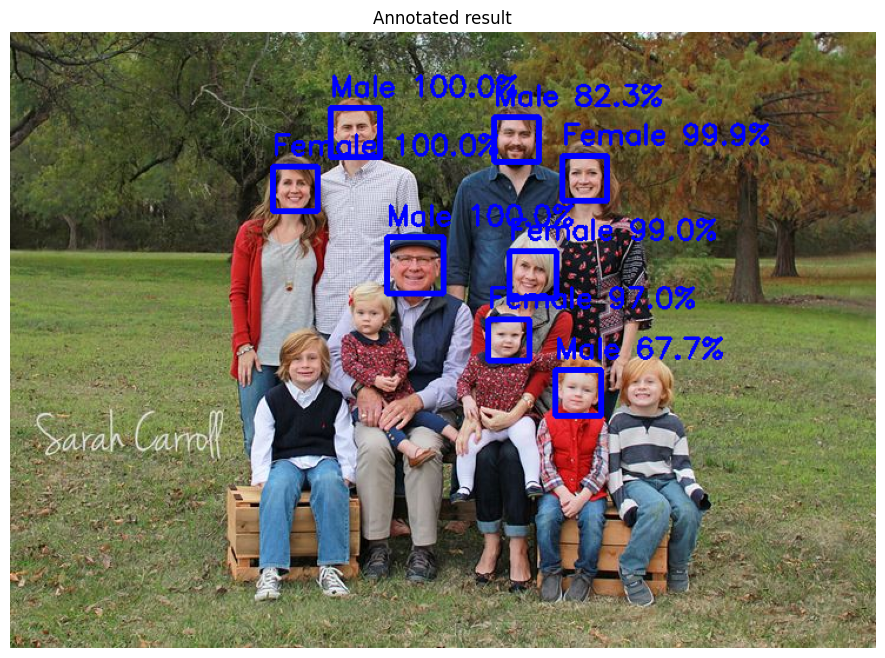

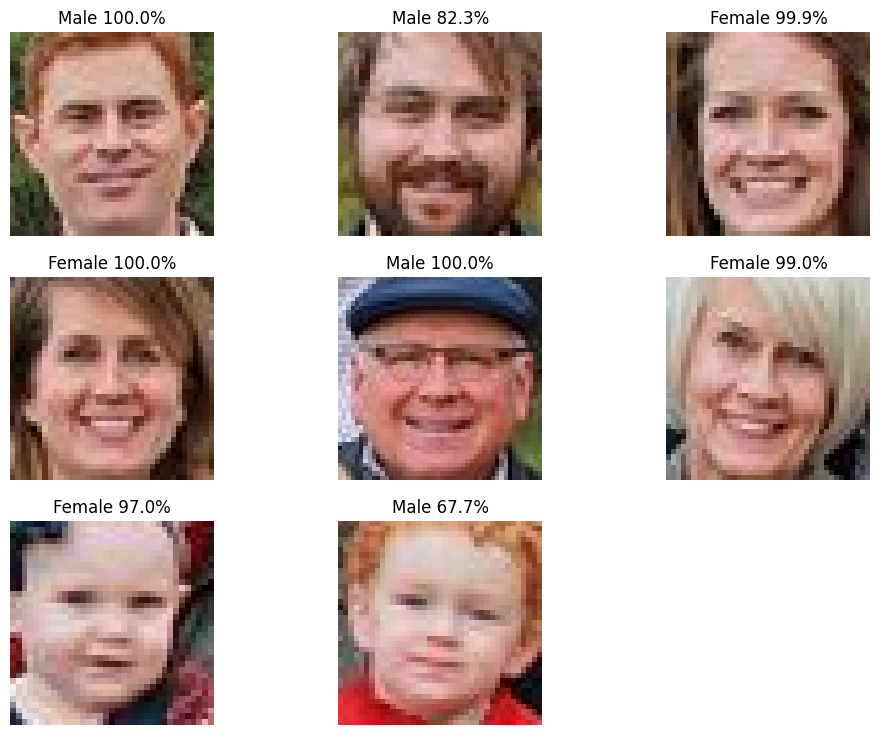

Saved annotated image to: dp1 photo (1)_annotated.jpg
Saved crop: dp1 photo (1)_face_crops/face_1_Male.jpg
Saved crop: dp1 photo (1)_face_crops/face_2_Male.jpg
Saved crop: dp1 photo (1)_face_crops/face_3_Female.jpg
Saved crop: dp1 photo (1)_face_crops/face_4_Female.jpg
Saved crop: dp1 photo (1)_face_crops/face_5_Male.jpg
Saved crop: dp1 photo (1)_face_crops/face_6_Female.jpg
Saved crop: dp1 photo (1)_face_crops/face_7_Female.jpg
Saved crop: dp1 photo (1)_face_crops/face_8_Male.jpg
All done. Use files.download('filename') to download from Colab if needed.


In [2]:
# Colab-ready Python script: face detection + gender prediction
# Save as colab_face_gender.py or paste into a Colab cell.

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm.auto import tqdm
from google.colab import files

def download_url(url, dst_path, chunk_size=8192):
    """Download a file with a progress bar (skips if already present)."""
    if os.path.exists(dst_path):
        print(f"Already downloaded: {dst_path}")
        return
    os.makedirs(os.path.dirname(dst_path) or ".", exist_ok=True)
    print(f"Downloading {url} -> {dst_path}")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    total = int(resp.headers.get("content-length", 0))
    with open(dst_path, "wb") as f, tqdm(total=total, unit='B', unit_scale=True, desc=os.path.basename(dst_path)) as pbar:
        for chunk in resp.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

# ------ model files (will be downloaded if missing) ------
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

FACE_PROTO_URL  = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
FACE_MODEL_URL  = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel"
GENDER_PROTO_URL = "https://raw.githubusercontent.com/smahesh29/Gender-and-Age-Detection/master/gender_deploy.prototxt"
GENDER_MODEL_URL = "https://raw.githubusercontent.com/smahesh29/Gender-and-Age-Detection/master/gender_net.caffemodel"

face_proto = os.path.join(model_dir, "deploy.prototxt")
face_model = os.path.join(model_dir, "res10_300x300_ssd_iter_140000_fp16.caffemodel")
gender_proto = os.path.join(model_dir, "gender_deploy.prototxt")
gender_model = os.path.join(model_dir, "gender_net.caffemodel")

download_url(FACE_PROTO_URL, face_proto)
download_url(FACE_MODEL_URL, face_model)
download_url(GENDER_PROTO_URL, gender_proto)
download_url(GENDER_MODEL_URL, gender_model)

print("Model files downloaded to:", model_dir)

# ------ upload an image in Colab ------
print("Upload an image file (jpg, png, etc.). Use the Colab file chooser that appears.")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded. Re-run this cell and upload an image.")
img_path = list(uploaded.keys())[0]
print("Uploaded:", img_path)

# ------ load networks and constants ------
face_net = cv2.dnn.readNetFromCaffe(face_proto, face_model)
gender_net = cv2.dnn.readNetFromCaffe(gender_proto, gender_model)
GENDER_LIST = ['Male', 'Female']
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

print("Loaded face and gender models.")

# ------ read image and run face detection ------
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise SystemExit("Failed to read image. Check file and try again.")

(h, w) = img_bgr.shape[:2]
print("Image shape:", img_bgr.shape)

blob = cv2.dnn.blobFromImage(cv2.resize(img_bgr, (300, 300)), 1.0, (300, 300),
                             (104.0, 177.0, 123.0), swapRB=False, crop=False)
face_net.setInput(blob)
detections = face_net.forward()
print("Detections shape:", detections.shape)

out = img_bgr.copy()
results = []
conf_threshold = 0.6  # adjust to 0.45-0.7 as needed

for i in range(detections.shape[2]):
    conf = float(detections[0, 0, i, 2])
    if conf < 0.01:
        continue
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    x1, y1, x2, y2 = box.astype(int)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w-1, x2), min(h-1, y2)
    print(f"Detection {i}: conf={conf:.3f}, box=({x1},{y1},{x2},{y2})")

    if conf >= conf_threshold:
        face = img_bgr[y1:y2, x1:x2]
        if face.size == 0:
            print("  Skipped empty ROI.")
            continue

        face_blob = cv2.dnn.blobFromImage(cv2.resize(face, (227, 227)), 1.0, (227, 227),
                                          MODEL_MEAN_VALUES, swapRB=False, crop=False)
        gender_net.setInput(face_blob)
        preds = gender_net.forward()
        gidx = int(preds[0].argmax())
        gender = GENDER_LIST[gidx]
        gconf = float(preds[0][gidx])

        results.append({"box": (x1, y1, x2, y2), "gender": gender, "gender_conf": gconf, "face": face})

        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 255, 0), 3)
        label = f"{gender} {gconf*100:.1f}%"
        y_text = y1 - 12 if y1 - 12 > 12 else y1 + 24
        cv2.putText(out, label, (x1, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    else:
        # draw low-confidence detections in red for debugging
        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(out, f"{conf:.2f}", (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

print(f"High-confidence faces found: {len(results)}")

# ------ Haar fallback if no DNN high-confidence results ------
if len(results) == 0:
    print("No high-confidence DNN detections — trying Haar cascade fallback.")
    haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    print("Haar found:", len(faces))
    out2 = img_bgr.copy()
    for (x, y, fw, fh) in faces:
        face = img_bgr[y:y + fh, x:x + fw]
        face_blob = cv2.dnn.blobFromImage(cv2.resize(face, (227, 227)), 1.0, (227, 227),
                                          MODEL_MEAN_VALUES, swapRB=False, crop=False)
        gender_net.setInput(face_blob)
        preds = gender_net.forward()
        gidx = int(preds[0].argmax())
        gender = GENDER_LIST[gidx]
        gconf = float(preds[0][gidx])

        cv2.rectangle(out2, (x, y), (x + fw, y + fh), (255, 0, 0), 3)
        cv2.putText(out2, f"{gender} {gconf*100:.1f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        results.append({"box": (x, y, x + fw, y + fh), "gender": gender, "gender_conf": gconf, "face": face})
    out = out2

# ------ display results ------
out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(out_rgb)
plt.axis('off')
plt.title("Annotated result")
plt.show()

if results:
    fig_cols = 3
    fig_rows = int(np.ceil(len(results) / fig_cols))
    plt.figure(figsize=(4 * fig_cols, 3 * fig_rows))
    for i, r in enumerate(results):
        x1, y1, x2, y2 = r["box"]
        face = r["face"]
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        plt.subplot(fig_rows, fig_cols, i + 1)
        plt.imshow(face_rgb)
        plt.title(f"{r['gender']} {r['gender_conf']*100:.1f}%")
        plt.axis('off')
    plt.show()
else:
    print("No faces detected by DNN or Haar. Try a clearer frontal image or lower conf_threshold.")

# ------ save annotated image and face crops ------
annotated_path = os.path.splitext(img_path)[0] + "_annotated.jpg"
cv2.imwrite(annotated_path, out)
print("Saved annotated image to:", annotated_path)

crop_dir = os.path.splitext(img_path)[0] + "_face_crops"
os.makedirs(crop_dir, exist_ok=True)
for idx, r in enumerate(results, start=1):
    sx, sy, ex, ey = r["box"]
    crop_file = os.path.join(crop_dir, f"face_{idx}_{r['gender']}.jpg")
    cv2.imwrite(crop_file, r["face"])
    print("Saved crop:", crop_file)

print("All done. Use files.download('filename') to download from Colab if needed.")
